# Control Variates for a GARCH model

### Add control variate (first order polynomial) to implement Zero variance Markov chain Monte Carlo Method (ZV-MCMC)

With the simple MCMC method, the estimator was determined by approximating the expectation of $g(x)$ a density function of combination of the 3 parameters going from $R^{3}$ to $R$, giving the data, based on the normal distribution (not standardized). To estimate this expectation we averaged the combinations of $M$ iterations of the 3 parameters simulated by the simple MCMC algorithm. We then get an estimate of $\mu_{g}$. The Zero variance Markov chain Monte Carlo method consists in reducing the MCMC error by replacing $g$ with a different function $f$, obtained by properly re-normalizing $g$. The function $f$ is constructed so that its expectation, equals $μ_{f}$, but its variance is much smaller.

ZV-MCMC Procedure:
- First step : run a short MCMC simulation to estimate the parameters of the control variates
- Second step : run a long simulation with the re-normalized posterior function to estimate the posterior mean of each parameter with less variance


### Libraries set up

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from scipy.optimize import minimize

### Simulation of data following a GARCH(1,1) process

We take the simulated garch process of question 1 (with parameters 0.3, 0.2, 0.5):

In [31]:
r_garch = pd.read_csv("r_garch.csv")
r_garch = np.array(r_garch["0"])

### First MCMC

We use a part of the sample simulated with the metropolis algorithm in MCMC_GARCH.ipynb to estimate coefficients:

In [32]:
zvmcmc_results_1step = pd.read_csv('mcmc_results.csv')

In [33]:
B=4000

We transform our 3 lists to be usable in our following function :

In [34]:
X_stack = np.vstack([zvmcmc_results_1step['omega'][B:], zvmcmc_results_1step['alpha'][B:], zvmcmc_results_1step['beta'][B:]])

In [35]:
X_stack = X_stack.T

### Control Variates estimation

The goal is to regress $g$ on $z$ with $z$ define as the gradient of the posterior function with respect to our three parameters. The posterior function $g$ and the gradient are explicitely defined as follow.

In [36]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial 
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [37]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garch)

1.412811897635871

In [47]:
g = list(map(lambda x: g(x, data=r_garch, h_initial=optimize_h(r_garch)), X_stack))

We compute the gradient in the same way. To define derivatives, we use the chain derivative method. That is, we derived $h(x)$ with respect to $x[i]$, with $i$ ranging from 0 to 2, then $g(h)$ with respect to $h$. Then we just multiply the two derivatives and sum over the whole garch process.

Derivative wrt x[0]:

In [39]:
def z1_i(r, h):
    return -0.5/h+0.5*(r**2)/(h**2) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def z1(x , data, h_initial):
    h = h_initial 
    LL = z1_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += z1_i(data[i],h)

    return LL

In [40]:
gradient1 = list(map(lambda x: z1(x, data=r_garch, h_initial=optimize_h(r_garch)), X_stack))

Derivative wrt x[1]:

In [41]:
def z2_i(r,h):
    return -0.5*(r**2)/h+0.5*(r**4)/(h**2)
def z2(x , data, h_initial):
    h = h_initial
    Z = z2_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z2_i(data[i],h)

    return Z

In [42]:
gradient2 = list(map(lambda x: z2(x, data=r_garch, h_initial=optimize_h(r_garch)), X_stack))

Derivative wrt x[2]:

In [43]:
def z3_i(r,h):
    return 0.5+0.5*(r**2)/h
def z3(x , data, h_initial):
    h = h_initial
    Z = z2_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z3_i(data[i],h)

    return Z

In [44]:
gradient3 = list(map(lambda x: z3(x, data=r_garch, h_initial=optimize_h(r_garch)), X_stack))

The dimension of the gradient is 3. We are looking for a vector of coefficient $a$ such that $f$, our re-normalized function, is equal to:

\begin{align*}  f(x) = g(x) - a^{t}*z \end{align*}

with $a$ equal to the vector of coefficients of an OLS regression of $g$ on $z$. 
$f$ is thus the predicted residuals of the regression of $g$ on $z$.
We use a simple OLS method robust to heteroscedascticity to estimate $a^{t}$, i.e the coefficients of the polynomial

In [48]:
X = np.vstack([gradient1, gradient2,gradient3]).T
y = g
model = sm.OLS(y, X).fit(cov_type='HC3') # ajustement du modèle de régression linéaire
print(model.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.207e+08
Date:                Thu, 27 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:16:01   Log-Likelihood:                         -2219.9
No. Observations:                1000   AIC:                                      4446.
Df Residuals:                     997   BIC:                                      4461.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Thanks to the estimated coefficients we can define $f$, our new function with a reduced variance :

In [49]:
def f_i(r, h):
    z1 = -0.5/h+0.5*(r**2)/(h**2)
    z2 = -0.5*(r**2)/h+0.5*(r**4)/(h**2)
    z3 = 0.5+0.5*(r**2)/h
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) - model.params[0] * z1 - model.params[1] * z2 - model.params[2] * z3 

def f(x , data, h_initial):
    h = h_initial 
    LL = f_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += f_i(data[i],h)

    return LL

### ZV-MCMC

The last step consists in running the algorithm again but with the new function f to calculate the density and accept or not the proposed combination.

Normaly it would be necessary to run a larger number of iteration than in the first step but the execution time is really expensive for my computer.

We can define the same parameters as in the first step. According to the specification we have to change the sigma, i.e. the volatility of the normal distribution, which allows us to propose a new combination of parameters, because the variance of the new density function, $f$, has decreased relative to the original $g$ function.

In [61]:
M = 5000 # size of the desired sample
X= [0.3, 0.2, 0.5] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.001  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Metropolis sampler :

In [62]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = f(Y, data = r_garch, h_initial=h_initial) - f(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)
        print((numaccept/M)*100,"%")

 ... 1000
18.86 %
 ... 2000
37.14 %
 ... 3000
55.60000000000001 %
 ... 4000
74.26 %
 ... 5000
92.9 %


### Exploitation of the results

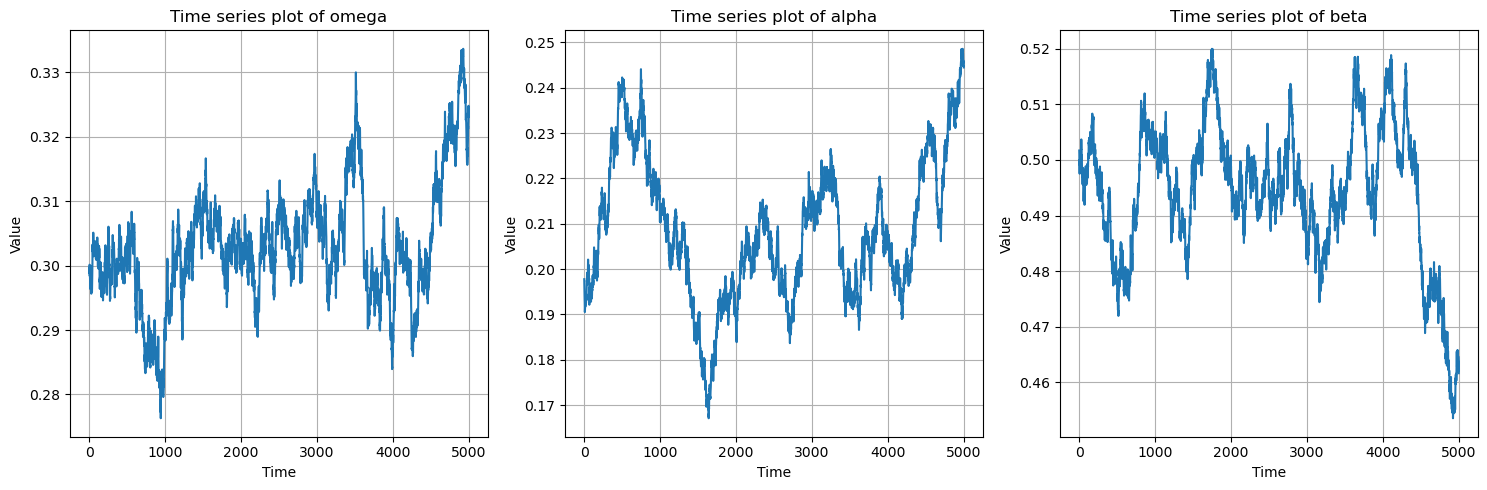

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [64]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

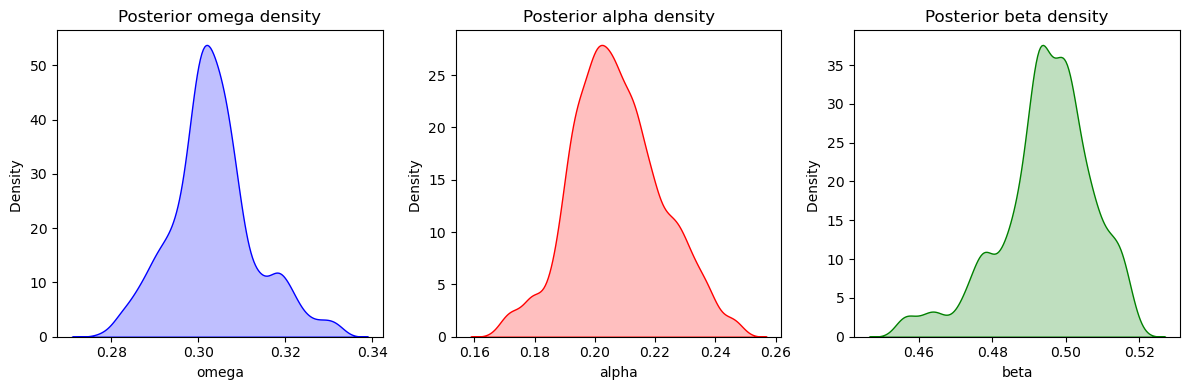

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [66]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 5000 iterations, with burn-in 600
acceptance rate = 0.9271277582050806
mean of x1 is about 0.30326551485199327
mean of x2 is about 0.2072531165486183
mean of x3 is about 0.4945834064038195


We calculate the standard error and the true standard error to determine the confidence intervals of our estimators:

In [67]:
def varfact(x): # function to get a variance factor used to obtain true standard error (because of the serial correlationn)
    acf_vals = acf(x, nlags=None, fft=True)  # acf comutation
    var_factor = 2 * np.sum(acf_vals) - 1  # variance factor computation
    return var_factor

In [68]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 0.001180869399829603
approximate 95% confidence interval of omega is ( 0.30095101082832726 , 0.3055800188756593 )

true standard error of alpha is about 0.0018716510531225738
approximate 95% confidence interval of alpha is ( 0.20358468048449807 , 0.21092155261273854 )

true standard error of beta is about 0.0015661771398638661
approximate 95% confidence interval of beta is ( 0.4915136992096863 , 0.49765311359795267 )



We store the 3 samples to compare MCMC in the following box plot :

In [69]:
zvmcmc_results_P1 = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
zvmcmc_results_P1.to_csv('zvmcmc_results_P1.csv', index=False)

In [70]:
mcmc_results = pd.read_csv("mcmc_results.csv")

By using the zero variance method, we observe a mean that is almost identical to the mean obtained with the standard Metropolis-Hastings algorithm (though this would require more iterations to confirm definitively). However, we can see that the variance of the estimates obtained using the zero variance method is significantly lower than that of the standard Metropolis-Hastings algorithm.

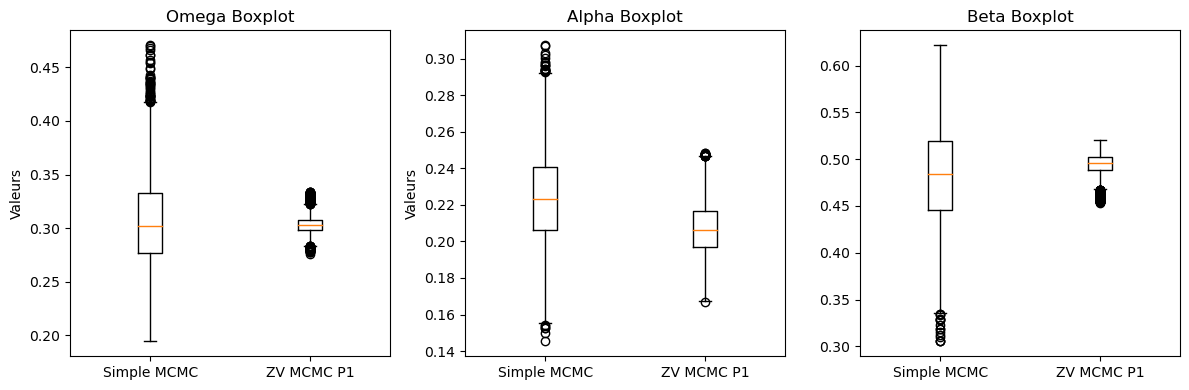

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Omega box-plot
axes[0].boxplot([mcmc_results['omega'][B:], zvmcmc_results_P1['omega'][B:]])
axes[0].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[0].set_ylabel('Valeurs')
axes[0].set_title('Omega Boxplot')

# Alpha box-plot
axes[1].boxplot([mcmc_results['alpha'][B:], zvmcmc_results_P1['alpha'][B:]])
axes[1].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[1].set_ylabel('Valeurs')
axes[1].set_title('Alpha Boxplot')

# Beta box-plot
axes[2].boxplot([mcmc_results['beta'][B:], zvmcmc_results_P1['beta'][B:]])
axes[2].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[2].set_title('Beta Boxplot')

# space between subplots
fig.tight_layout()

# Display
plt.show()